# Imports

In [3]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import glob
import yaml
import torch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from sklearn.model_selection import train_test_split

# Install YOLOv8

In [4]:
%pip install ultralytics

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.93 🚀 Python-3.7.12 torch-1.12.0+cpu CPU
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 4637.7/8062.4 GB disk)


# Create Directory

In [6]:
directory = "/kaggle/input/face-mask-detection"
image_directory = directory + "/images"
annotation_directory = directory + "/annotations"
annotations = list(Path(annotation_directory).glob(r'**/*{}'.format('xml')))

# Data Preprocessing

In [7]:
class_id = {
    "with_mask" : 0,
    "mask_weared_incorrect" : 1,
    "without_mask" : 2
}

data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text
        
        bbox = []
        # bndbox has xmin, ymin, xmax, ymax
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')
        
        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

df_data = pd.DataFrame(data_dict)

df_data.head()

filename                  label  class_id  width  height  \
0  maksssksksss737.png              with_mask         0    400     226   
1  maksssksksss737.png              with_mask         0    400     226   
2  maksssksksss737.png  mask_weared_incorrect         1    400     226   
3  maksssksksss737.png              with_mask         0    400     226   
4  maksssksksss737.png              with_mask         0    400     226   

               bboxes  
0    [28, 55, 46, 71]  
1   [98, 62, 111, 78]  
2  [159, 50, 193, 90]  
3  [293, 59, 313, 80]  
4  [352, 51, 372, 72]

In [8]:
df_data.isna().sum()

filename    0
label       0
class_id    0
width       0
height      0
bboxes      0
dtype: int64

In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   class_id  4072 non-null   int64 
 3   width     4072 non-null   int64 
 4   height    4072 non-null   int64 
 5   bboxes    4072 non-null   object
dtypes: int64(3), object(3)
memory usage: 191.0+ KB


In [10]:
df_data.label.unique()

array(['with_mask', 'mask_weared_incorrect', 'without_mask'], dtype=object)

In [11]:
print(f"Total 'without_mask' labels: {sum(df_data.label == 'without_mask')}")
print(f"Total 'mask_weared_incorrect' labels: {sum(df_data.label == 'mask_weared_incorrect')}")
print(f"Total 'with_mask' labels: {sum(df_data.label == 'with_mask')}")

Total 'without_mask' labels: 717
Total 'mask_weared_incorrect' labels: 123
Total 'with_mask' labels: 3232


# Visualize Data

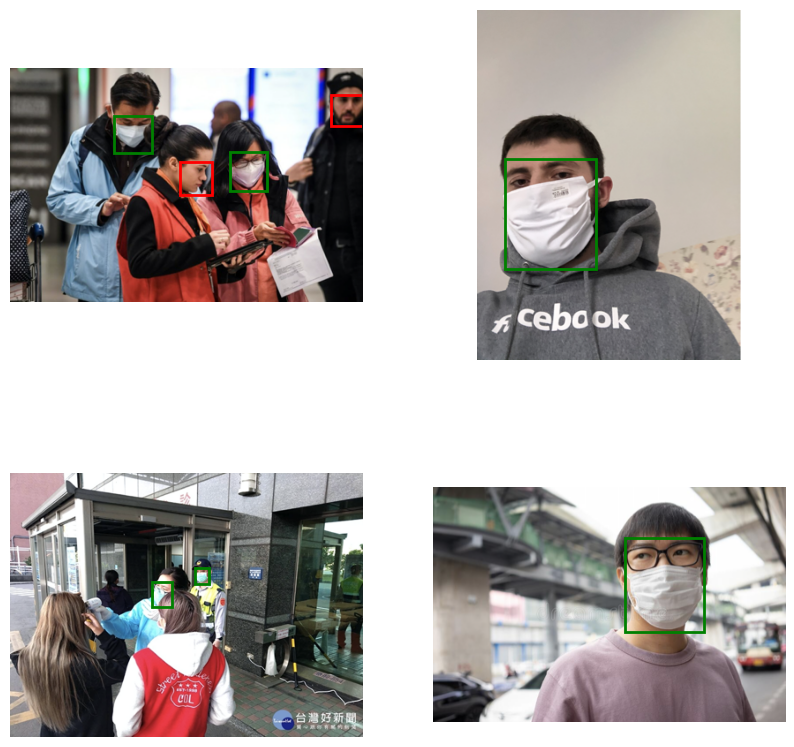

In [12]:
def show_random_images_with_bbox(df):
    all_images = os.listdir(image_directory)
    random_image_filename = random.sample(all_images, 4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, filename in enumerate(random_image_filename):
        selected_df = df[df['filename'] == filename]
        
        image = Image.open(image_directory + '/' + filename)
        
        ax.flat[i].imshow(image)
        ax.flat[i].axis(False)
        
        image_bboxes = []
        for df_index in range(0, len(selected_df)):
            color = "g"
            if selected_df.iloc[df_index].class_id == 1: color = "y"
            elif selected_df.iloc[df_index].class_id == 2: color = "r"
            
            x_min, y_min, x_max, y_max = selected_df.iloc[df_index].bboxes
            
            rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min, 
                             linewidth=2, edgecolor=color, facecolor="none")
            ax.flat[i].add_patch(rect)
            
show_random_images_with_bbox(df_data)

In [13]:
# we need to convert our bbox format to yolo as the current one that we have is on pascal_voc
def pascal_voc_to_yolo_bbox(bbox_array, w, h):
    x_min, y_min, x_max, y_max = bbox_array
    
    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h
    
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return [x_center, y_center, width, height]

# Split Train, Val, Test images

Create our directory to place our images

In [14]:
train_path = "/kaggle/working/datasets/train"
valid_path = "/kaggle/working/datasets/valid"
test_path = "/kaggle/working/datasets/test"

os.mkdir("/kaggle/working/datasets")
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

We need to move our respective images to its folder and create label file for our image to use in YOLOv8

In [15]:
train, test = train_test_split(df_data.filename.unique(), test_size=0.2, random_state=23)
train, valid = train_test_split(train, test_size=0.15, random_state=23)

def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        fileName = Path(image).stem
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_voc_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")
                

copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [16]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(glob.glob(filepath + '/*.png', recursive = True))} images in '{dirpath}'.")
    
walk_through_dir(train_path)
walk_through_dir(valid_path)  
walk_through_dir(test_path)  

There are 0 directories and 579 images in '/kaggle/working/datasets/train'.
There are 0 directories and 103 images in '/kaggle/working/datasets/valid'.
There are 0 directories and 171 images in '/kaggle/working/datasets/test'.


# Create YAML file

In [17]:
classes = list(df_data.label.unique())
class_count = len(classes)
facemask_yaml = f"""
    train: train
    val: valid
    test: test
    nc: {class_count}
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    """

with open('facemask.yaml', 'w') as f:
    f.write(facemask_yaml)
    
%cat facemask.yaml

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)

    train: train
    val: valid
    test: test
    nc: 3
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    

# Train

In [18]:
model = YOLO("yolov8n.pt") 
model.train(data="facemask.yaml", epochs=5)

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.93 🚀 Python-3.7.12 torch-1.12.0+cpu CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=facemask.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace=4, nms=False, lr0=0.01, 

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias
train: Scanning /kaggle/working/datasets/train... 579 images, 0 backgrounds, 0 corrupt: 100%|██████████| 579/579 [00:01<00:00, 382.34it/s]
train: New cache created: /kaggle/working/datasets/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/datasets/valid... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<00:00, 374.43it/s]
val: New cache created: /kaggle/working/datasets/valid.cache
Plotting labels to runs/detect/train/labels.jpg... 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
  0%|          | 0/37 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/

In [19]:
model.val(data="facemask.yaml")

Ultralytics YOLOv8.0.93 🚀 Python-3.7.12 torch-1.12.0+cpu CPU
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/datasets/valid.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]
                   all        103        559      0.895      0.486      0.537       0.32
             with_mask        103        463      0.889      0.842      0.895       0.55
 mask_weared_incorrect        103         14          1          0     0.0389     0.0203
          without_mask        103         82      0.795      0.616      0.676      0.389
Speed: 1.3ms preprocess, 88.3ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/detect/val


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x785bd8b00fd0>
fitness: 0.3415714576568362
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.54996,    0.020348,      0.3894])
names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
plot: True
results_dict: {'metrics/precision(B)': 0.8948911047856267, 'metrics/recall(B)': 0.4862333366124946, 'metrics/mAP50(B)': 0.5365946337007297, 'metrics/mAP50-95(B)': 0.3199022158741814, 'fitness': 0.3415714576568362}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 1.3351602461731549, 'inference': 88.30291553608423, 'loss': 0.00016434678753602853, 'postprocess': 5.95469382202741}

# Validation

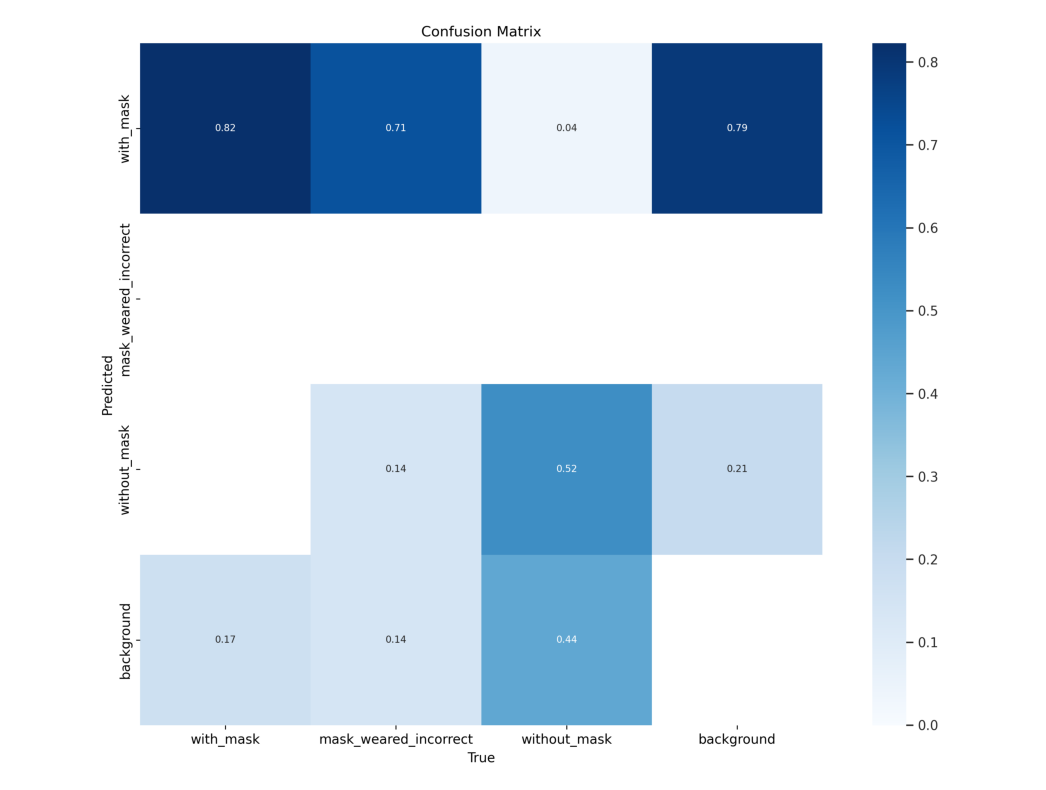

In [20]:
confusion_matrix = Image.open("/kaggle/working/runs/detect/train/confusion_matrix.png")
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

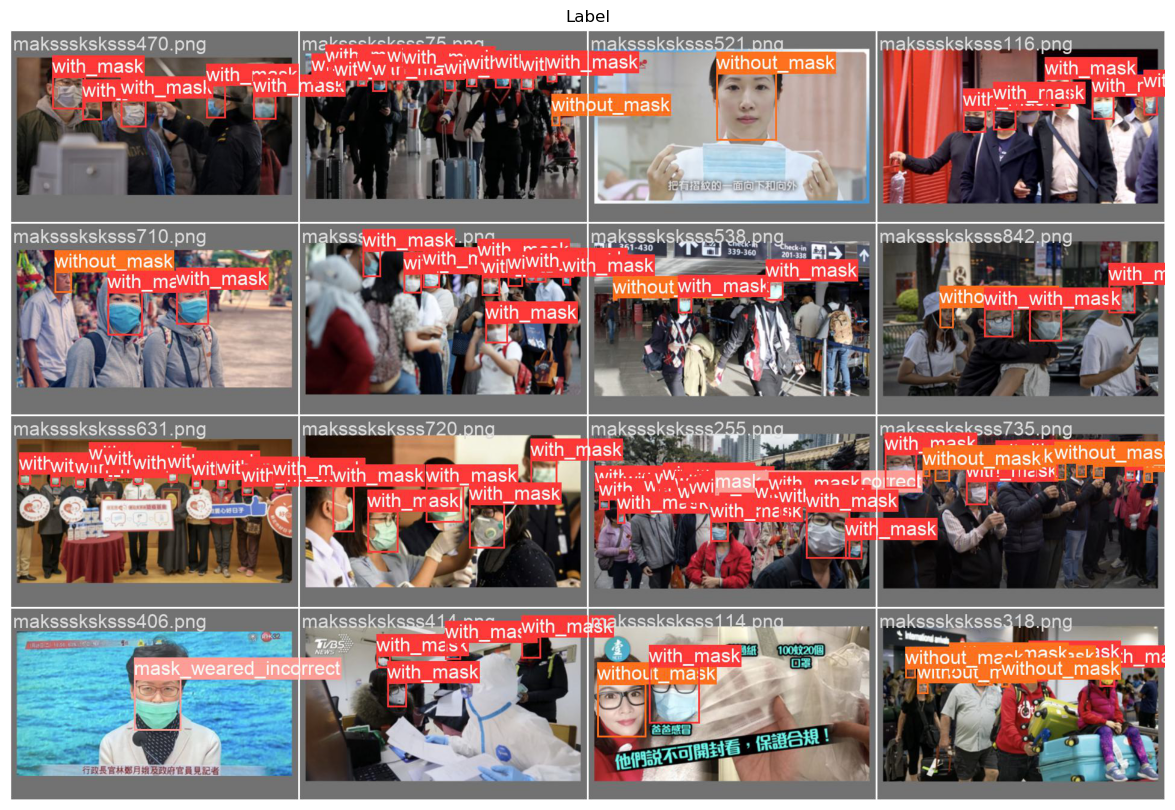

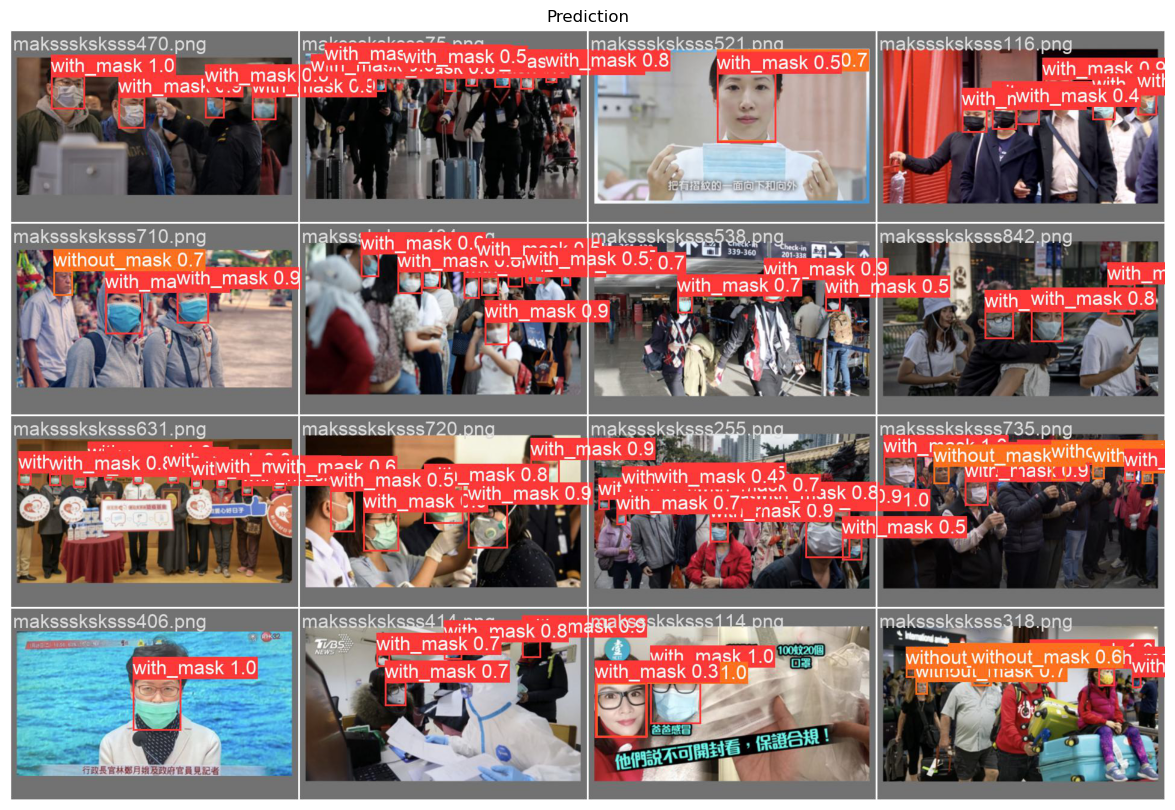

In [21]:
val_label = Image.open("/kaggle/working/runs/detect/train/val_batch0_labels.jpg")
val_pred = Image.open("/kaggle/working/runs/detect/train/val_batch0_pred.jpg")

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

# Predict

In [22]:
model = YOLO(model="/kaggle/working/runs/detect/train/weights/best.pt")

In [23]:
filenames = glob.glob(test_path+"/*.png", recursive=False)
test_image1 = cv2.imread(filenames[0])
test_image2 = cv2.imread(filenames[1])

results = model.predict([test_image1, test_image2], save=True, line_thickness=1)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'line_width' instead.

0: 640x640 1 with_mask, 1: 640x640 1 with_mask, 243.4ms
Speed: 2.8ms preprocess, 121.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


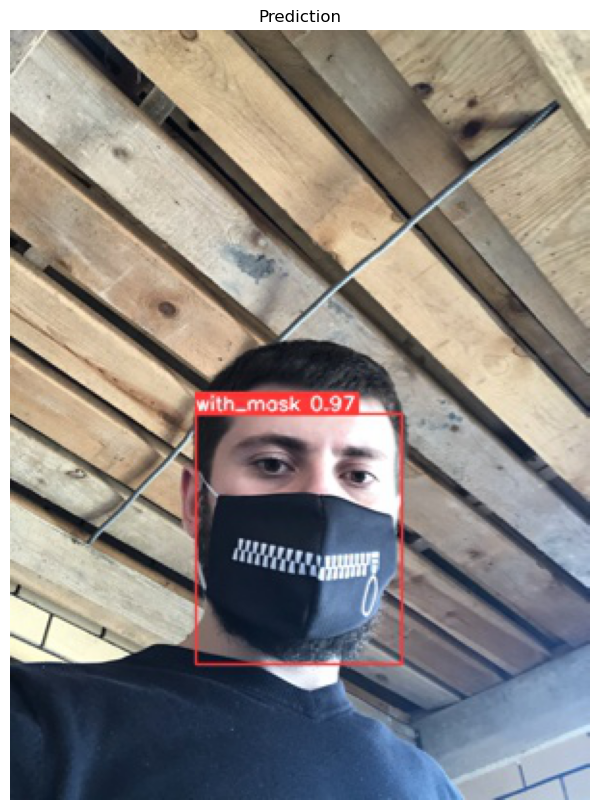

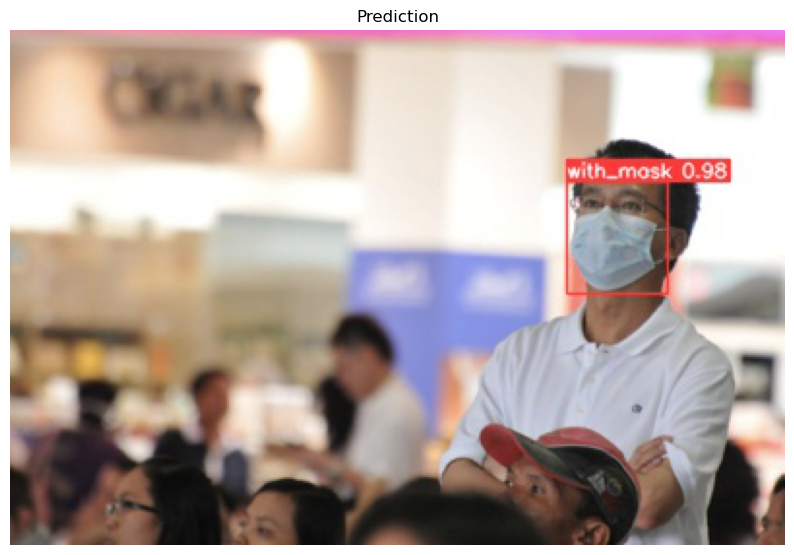

In [24]:
predicted_image = Image.open("runs/detect/predict/image0.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()

predicted_image = Image.open("runs/detect/predict/image1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()